In [1]:
import os
import time
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, cross_val_score as CVS
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd

paras_path = './paras_data/'
files = os.listdir(paras_path)
dfs = []
for file in files:
    if file.endswith('.xlsx'):
        file_path = os.path.join(paras_path, file)
        df = pd.read_excel(file_path)
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)


In [3]:
combined_df.head()

,open_0_10_mean,high_0_10_mean,low_0_10_mean,close_0_10_mean,open_0_10_sum,high_0_10_sum,low_0_10_sum,close_0_10_sum,open_0_10_max,high_0_10_max,...,open_0_720_min,high_0_720_min,low_0_720_min,close_0_720_min,open_0_720_std,high_0_720_std,low_0_720_std,close_0_720_std,y_7,label
0,15.386350,15.592550,15.328050,15.484950,30.7727,31.1851,30.6561,30.9699,15.4222,15.6015,...,15.3505,15.5836,15.2877,15.3863,0.050700,0.012657,0.057064,0.139512,16.4802,1
1,15.365433,15.580600,15.326567,15.475967,46.0963,46.7418,45.9797,46.4279,15.4222,15.6015,...,15.3236,15.5567,15.2877,15.3863,0.050968,0.022550,0.040432,0.099870,16.4802,1
2,15.413250,15.655325,15.366150,15.561150,61.6530,62.6213,61.4646,62.2446,15.5567,15.8795,...,15.3236,15.5567,15.2877,15.3863,0.104296,0.150580,0.085774,0.188876,16.4802,1
3,15.497520,15.719880,15.409640,15.579980,77.4876,78.5994,77.0482,77.8999,15.8346,15.9781,...,15.3236,15.5567,15.2877,15.3863,0.208963,0.194531,0.122371,0.168904,16.4802,1
4,15.516350,15.730033,15.440117,15.594033,93.0981,94.3802,92.6407,93.5642,15.8346,15.9781,...,15.3236,15.5567,15.2877,15.3863,0.192509,0.175763,0.132487,0.154944,16.4802,1


In [4]:
from sklearn import preprocessing
feature_col = df.columns.to_list()
feature_col.remove('label')
modle_num = preprocessing.StandardScaler()
combined_df.loc[:,feature_col] = modle_num.fit_transform(combined_df.loc[:,feature_col])

In [5]:
features = combined_df.drop('label', axis=1)
label = combined_df['label']
X_train, X_test, y_train, y_test = train_test_split(
    features,
    label,
    test_size=0.2,
    random_state=1,
    stratify=label
)

## lr

In [6]:
clf = LogisticRegression(max_iter=1000,random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

精确率为：0.7541322314049587
召回率为：0.7486990756590208
f1分数为：0.7505527940042578
auc分数为：0.7486990756590209


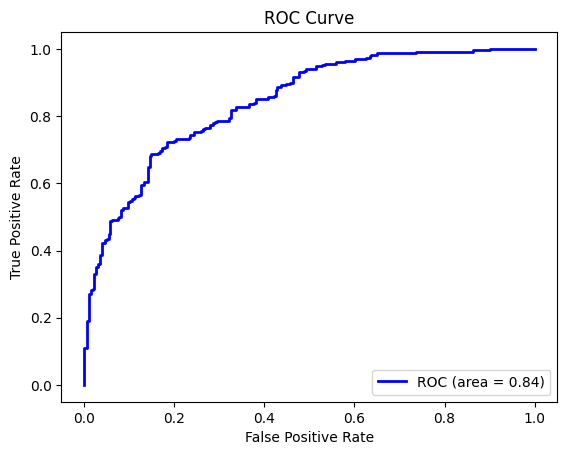

In [7]:
from sklearn import metrics
import matplotlib.pyplot as plt
#预测测试集
predictions = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)[:,1]

acc = metrics.accuracy_score(y_test, predictions) 
print('精确率为：{}'.format(acc))

rcall = metrics.recall_score(y_test, predictions,average='macro') 
print('召回率为：{}'.format(rcall))
f1 = metrics.f1_score(y_test, predictions,average='weighted') 
print('f1分数为：{}'.format(f1))
auc = metrics.roc_auc_score(y_test, predictions) 
print('auc分数为：{}'.format(auc))


fpr, tpr, thersholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

## dnn

In [8]:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import pandas as pd
import numpy as np
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

In [9]:
class Mydata(Dataset):
    def __init__(self,data):
        self.df = data.values
    def __getitem__(self,idx):
        features = self.df[idx,:-1]
        label    = self.df[idx,-1]
        return features,label
    def __len__(self):
        data_lens = self.df.shape[0]
        return data_lens

# 自定义三层神经网络，由于特征有限，且大部分特征为0，如果定义太多层神经网络，可能导致模型无法收敛
# 定义神经网络类
class Net(nn.Module):
    def __init__(self,input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 25)
        self.fc3 = nn.Linear(25, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [12]:
# 可调超参数：n_hidden、epochs、n_hidden
# 1. 数据集读取
train_data = X_train
train_data['label'] = y_train
train_val_df,val_df = train_test_split(train_data,test_size=0.2,random_state=1)
test_data = X_test
test_data['label'] = y_test
input_len = df.shape[1]-1
train_Dataset = Mydata(train_val_df)
val_Dataset = Mydata(val_df)
train_dataloader = DataLoader(train_Dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_Dataset, batch_size=32, shuffle=True)

model = Net(input_len)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 定义训练轮数
num_epochs = 10

model.to(device)
criterion.to(device)

# 训练模型
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    # 训练模式
    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.float()
        labels = labels.reshape(-1,1)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        # 计算训练损失和准确率
        train_loss += loss.item() * inputs.size(0)
        train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels.data)
        
    # 验证模式
   
    for inputs, labels in val_dataloader:
        inputs = inputs.float()
        labels = labels.reshape(-1,1)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels.float())
        
        # 计算验证损失和准确率
        val_loss += loss.item() * labels.size(0)
        val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels.data)
    
    # 计算平均损失和准确率
    train_loss = train_loss / len(train_dataloader.dataset)
    train_acc = train_acc / len(train_dataloader.dataset)
    val_loss = val_loss / len(val_dataloader.dataset)
    val_acc = val_acc / len(val_dataloader.dataset)
    
    # 打印训练结果
    if epoch%20 ==0:
        print("Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}".format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))


Epoch [1/10], Train Loss: 0.6910, Train Acc: 16.8854, Val Loss: 0.6785, Val Acc: 15.7183


In [13]:
test = torch.Tensor(test_data.iloc[:,:-1].values)
model.eval()
pred_y = model(test)
pred_y = pred_y.reshape(1,-1)[0]
pred_y = pred_y.detach().numpy()

tmp = list()
for i in pred_y:
    tmp.append(1 if i > 0.5 else 0)
tmp = np.array(tmp)

精确率为：0.6673553719008265
召回率为：0.667048955837042
f1分数为：0.667490480559282
auc分数为：0.6670489558370422


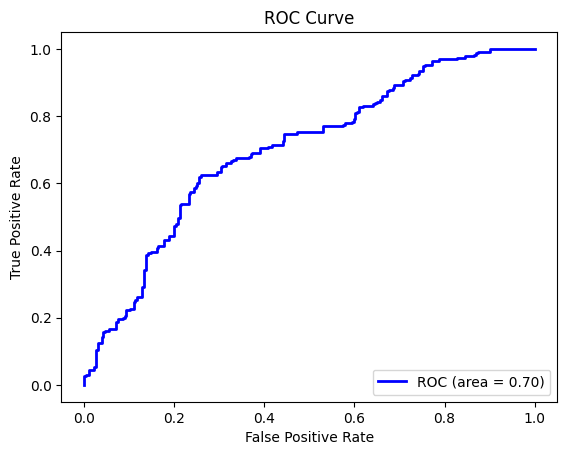

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt
predictions = tmp
pred_prob = pred_y
acc = metrics.accuracy_score(y_test, predictions) 
print('精确率为：{}'.format(acc))

rcall = metrics.recall_score(y_test, predictions,average='macro') 
print('召回率为：{}'.format(rcall))
f1 = metrics.f1_score(y_test, predictions,average='weighted') 
print('f1分数为：{}'.format(f1))
auc = metrics.roc_auc_score(y_test, predictions) 
print('auc分数为：{}'.format(auc))


fpr, tpr, thersholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")